# Utility Scale

## Introduction

Continuing the trend of following IBM's tutorials, but with the twist of making the walkthrough more understandable for mere mortals. This also gives me the opportunity to explore interesting rabbit holes. The plan is to tackle part 2 of: [IBM Quantum Tutorials](https://quantum.cloud.ibm.com/docs/en/tutorials/hello-world).

This time, rather than experimenting with two qubits, we will experiment at a "Utility" (i.e., Useful) scale by analyzing a 100-qubit GHZ state and measuring the expectation value for the ZZ Operator.

### What is GHZ?

What is a GHZ state, you might ask? I had the exact same question. Greenberger–Horne–Zeilinger (GHZ) state is essentially, alot like the Bell State, but bigger, where an n-qubit system exhibits strong quantum correlations. Similar to the 2-qubit state, a 3-qubit GHZ state can be expressed using the following expression:

|ψ⟩ = 1/√2 (|000⟩ + |111⟩)

## Step 1 - Create the circuit

As the usual step of these Quantum Projects using qiskit, we need to begin by defining the Quantum Circuit. In this case, we need to create a circuit to set up a n-qubit GHZ state.

In the code below, we are setting up a function that takes in n, the number of qubits and returns a quantum circuit. 
1. We initiate a quantum circuit with n qubits
2. We apply the Hadamard gate to qubit 0, if you remember from "Hello World" this puts qubit 0 into a superposition.
$$ |0\rangle \rightarrow \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle) $$

3. Loops through qubits 1 to n–1. Applies a CNOT gate from qubit 0 (control) to each other qubit (target).
$$ |\text{GHZ}_n\rangle = \frac{1}{\sqrt{2}} (|0\rangle^{\otimes n} + |1\rangle^{\otimes n}) $$

4. Then we return the QC



In [1]:
from qiskit import QuantumCircuit

def create_ghz_circuit(n: int) -> QuantumCircuit:
    qc = QuantumCircuit(n)
    qc.h(0)  # Apply Hadamard gate to the first qubit
    for i in range(1, n):
        qc.cx(0, i)  # Apply CNOT gates from the first qubit to all others
    return qc

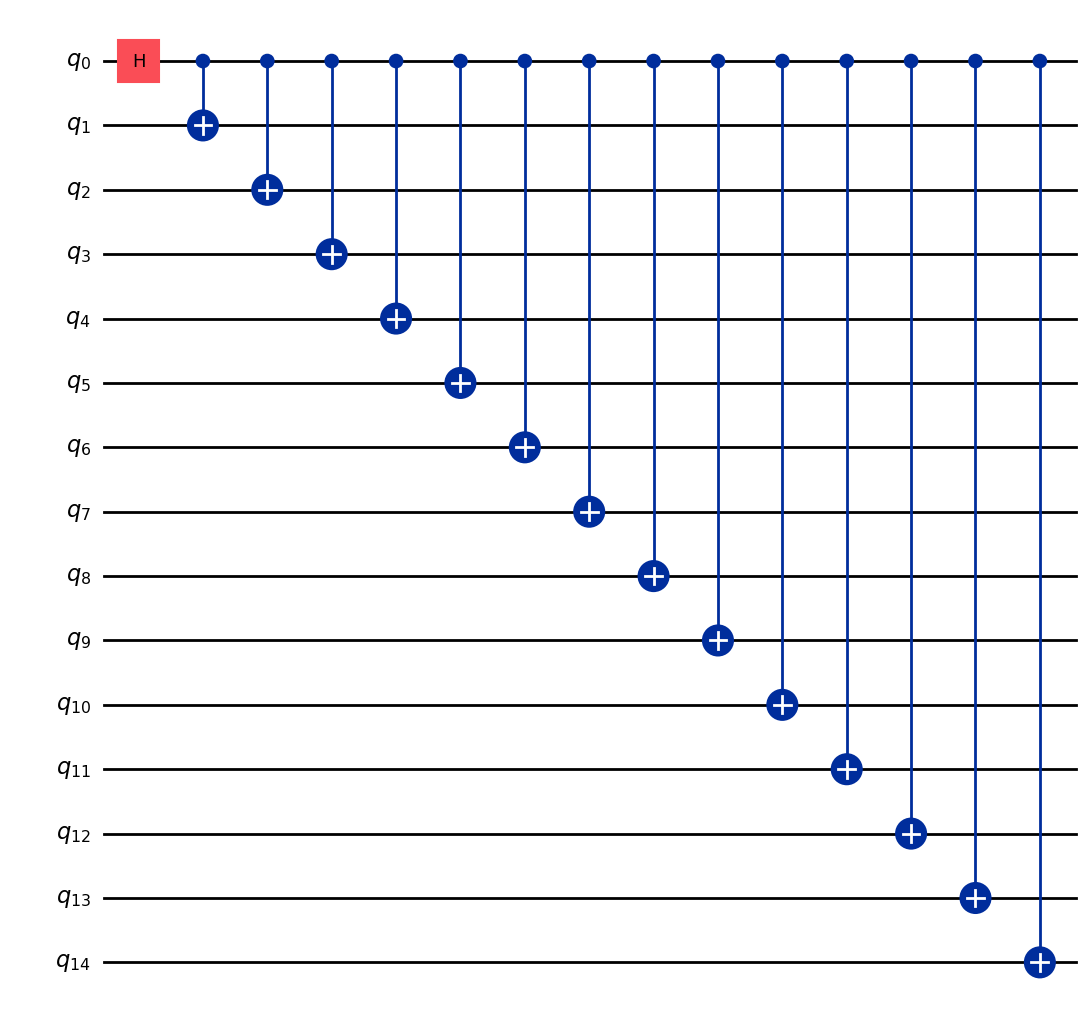

In [6]:
# Let's make this interactive for n qubits
n = 15

qc = create_ghz_circuit(n)
qc.draw('mpl')

## Step 2: Setting up the observables

This example uses the ZZ operators between qubits to examine the behavior as they get farther apart. Increasingly inaccurate (corrupted) expectation values between distant qubits would reveal the level of noise present.

In a real quantum processor, qubits are laid out physically. When you entangle qubit 0 with qubit 99 (in a 100-qubit GHZ state), the signal has to travel across many intermediate qubits and gates. This introduces:
- Decoherence - the loss of information due to interaction with the environment such as stray electromagnetic fields or thermal noise
- Cross-talk between qubits - when one qubits unintentionally affects another
- Gate errors - as the name suggests, gate's not doing behaving perfectly
So, by measuring ⟨Z₀Zᵢ⟩ for increasing values of i, you can diagnose how noise accumulates as qubits get farther apart.


### But what is an operator?

Operators can act as both a function, or a measurement. 

Think of it like a function that takes a quantum state as input and gives you a new state or a measurable value.

$$\hat{O} \, |\psi\rangle = |\phi\rangle$$
$$\text{This means the operator } \hat{O} \text{ transforms the state } |\psi\rangle \text{ into a new state } |\phi\rangle.$$

Take the Hadamard gate...


So for Pauli-Z Opearator, we are using it to measure spin along the Z-axis.

So when you measure a qubit in the Z basis, you’re asking: “Is this qubit in $$|0\rangle \text{ or } |1\rangle$$

In this context we care about Pauli Operators (for the measurement of spin) and H??? , but there are others used in quantum mechanics:
- The Hamiltonian operator gives the total energy of the system



In [14]:
from qiskit.quantum_info import SparsePauliOp
 
operator_strings = []
for i in range(n - 1):
    ops = ["I"] * n
    ops[0] = "Z"
    ops[i + 1] = "Z"
    operator_strings.append("".join(ops))

print(operator_strings)
print(len(operator_strings))
 
observables = [SparsePauliOp(operator) for operator in operator_strings]

['ZZIIIIIIIIIIIII', 'ZIZIIIIIIIIIIII', 'ZIIZIIIIIIIIIII', 'ZIIIZIIIIIIIIII', 'ZIIIIZIIIIIIIII', 'ZIIIIIZIIIIIIII', 'ZIIIIIIZIIIIIII', 'ZIIIIIIIZIIIIII', 'ZIIIIIIIIZIIIII', 'ZIIIIIIIIIZIIII', 'ZIIIIIIIIIIZIII', 'ZIIIIIIIIIIIZII', 'ZIIIIIIIIIIIIZI', 'ZIIIIIIIIIIIIIZ']
14


## Step 3: Butchering the Circuit

Butchering may be a little harsh, but its transpiling time to make the QC more appetisable for the specific backend.

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get credentials from environment variables
token = os.getenv('IBM_QUANTUM_TOKEN')
instance = os.getenv('IBM_QUANTUM_INSTANCE')

if token is None:
    raise ValueError("Please set IBM_QUANTUM_TOKEN in your .env file")

# Save and create the service
QiskitRuntimeService.save_account(
    token=token,
    instance=instance,
    overwrite=True
)

service = QiskitRuntimeService()
print("Successfully connected to IBM Quantum!")

management.get:WARNING:2025-10-10 18:45:35,558: Loading default saved account


Successfully connected to IBM Quantum!


So next we find the least busy backend that will work for our needs, e.g. operational, not a simulator, and has the minimum number of qubits.

Next we pull the present managers that has been configured for the backend, this essentially converts our gates into a set of gates that actually work on the janky hardware of today.

<IBMBackend('ibm_torino')>


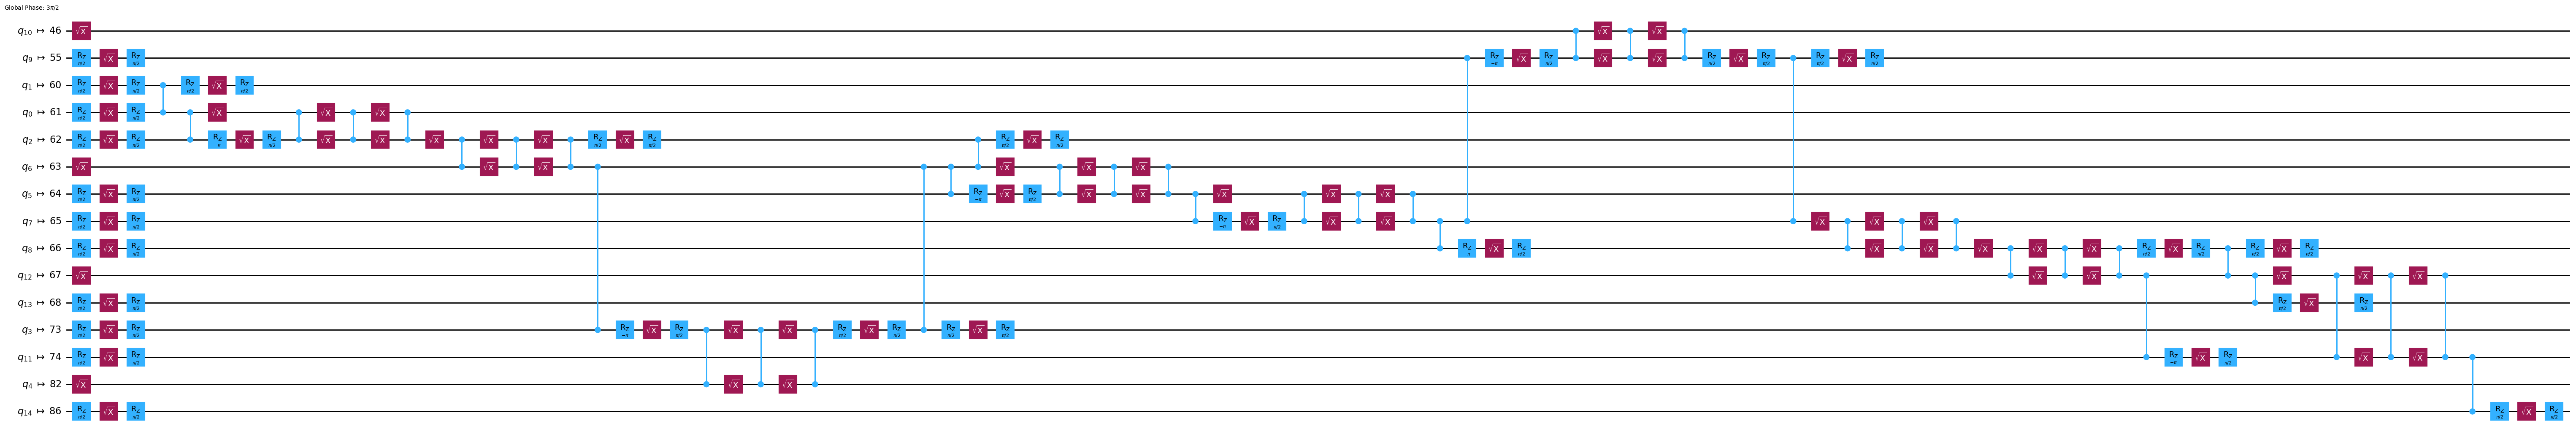

In [ ]:
from qiskit.transpiler import generate_preset_pass_manager

backend = service.least_busy(simulator=False, operational=True, min_num_qubits=n)
print(backend) 

pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
print(pm)

transpiled_qc = pm.run(qc)
transpiled_qc.draw('mpl',  fold=-1, style="clifford")


In [7]:
print(qc.count_ops())
print(transpiled_qc.count_ops())

OrderedDict({'cx': 14, 'h': 1})
OrderedDict({'sx': 93, 'rz': 58, 'cz': 50})


Christ almighty, I think butchering our beautiful QC was the right wording. But there is a few things to notice from the comparison:

- We are goinfg from 15 gates to over 200!
- The CX is being decomposed into CZ + Hadamard = CX =(I⊗H)⋅CZ⋅(I⊗H)
- The hadamard is being decomposed to H=RZ(π)⋅SX⋅RZ(π)
- sx and rz are native single-qubit gates on many quantum devices 


## Callout

Interestingly, I was messing around with the style and I noticed that the transpiled circuit actually changed everytime I run the transpilation????

So it turns out the optimisation process uses randomisation to explore layouts. You actually need a seed to make it deterministic

transpiled_qc = pm.run(qc, seed_transpiler=42)


## Step 4: The Execution

Things to note:
- Resilience level denotes: 
- The tutorial used 5000 shots, I'm gonna use 50, because I'm running out of free QPU time...
- To create the mapped observables we...
- One pub, with one circuit to run against five different observables.

In [ ]:
from qiskit_ibm_runtime import Estimator

estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 50

mapped_observables = [observable.apply_layout(transpiled_qc.layout) for observable in observables]

quantum_food = [(transpiled_qc, mapped_observables)]

print(quantum_food)

job = estimator.run(quantum_food)

print(job.job_id())


[(<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x126c3b410>, [SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j]), Sp

In [ ]:
d3kc31hfk6qs73emclqg